<a href="https://colab.research.google.com/github/shahedmomenzadeh/generative_models_journey/blob/main/H_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In a standard VAE, we only have one latent variable, so the math results in a single KL divergence term. In an HVAE, because we have multiple interacting latent variables ($z_1$ and $z_2$), expanding the ELBO naturally produces multiple KL divergence terms.Here is the complete derivation from scratch, showing exactly how the math translates into the two distinct KL loss terms we wrote in the code.1. Defining the FactorizationsBefore we do the math, we must define how our specific HVAE architecture makes decisions.The Generative Model (Top-Down / Decoder):The true joint probability of our data and latent variables is factored as:$$p(x, z_1, z_2) = p(x | z_1) p(z_1 | z_2) p(z_2)$$$p(z_2)$ is the top-level prior, which we fix as a standard normal $\mathcal{N}(0, I)$.$p(z_1 | z_2)$ is the prior for $z_1$, which is dynamically generated by a neural network based on $z_2$.$p(x | z_1)$ is the final image reconstruction.The Inference Model (Bottom-Up / Encoder):The approximate posterior distribution is factored as:$$q(z_1, z_2 | x) = q(z_1 | x) q(z_2 | z_1)$$$q(z_1 | x)$ extracts the first-level latent features from the image.$q(z_2 | z_1)$ extracts the highest-level latent features from $z_1$.2. Deriving the HVAE ELBOThe goal of any VAE is to maximize the log-likelihood of the data, $\log p(x)$. Because this is intractable to compute directly, we introduce our approximate posterior $q(z_1, z_2 | x)$ and use Jensen's Inequality to derive a lower bound (the ELBO).$$\log p(x) \geq \mathbb{E}_{q(z_1, z_2 | x)} \left[ \log \frac{p(x, z_1, z_2)}{q(z_1, z_2 | x)} \right]$$Now, we substitute our specific top-down and bottom-up factorizations into this equation:$$\text{ELBO} = \mathbb{E}_{q} \left[ \log \frac{p(x | z_1) p(z_1 | z_2) p(z_2)}{q(z_1 | x) q(z_2 | z_1)} \right]$$Using the properties of logarithms ($\log(abc/de) = \log(a) + \log(b) + \log(c) - \log(d) - \log(e)$), we can break this massive fraction into individual expected values:$$\text{ELBO} = \mathbb{E}_q[\log p(x | z_1)] + \mathbb{E}_q \left[ \log \frac{p(z_2)}{q(z_2 | z_1)} \right] + \mathbb{E}_q \left[ \log \frac{p(z_1 | z_2)}{q(z_1 | x)} \right]$$By pulling a negative sign out of the last two terms to flip the fractions, the definition of KL divergence ($D_{KL}(q \parallel p) = \mathbb{E}_q[\log \frac{q}{p}]$) naturally emerges!$$\text{ELBO} = \mathbb{E}_q[\log p(x | z_1)] - \mathbb{E}_q \left[ \log \frac{q(z_2 | z_1)}{p(z_2)} \right] - \mathbb{E}_q \left[ \log \frac{q(z_1 | x)}{p(z_1 | z_2)} \right]$$This gives us our final loss function components:Reconstruction Loss: $\mathbb{E}_q[\log p(x | z_1)]$Top-Level KL: $D_{KL}(q(z_2 | z_1) \parallel p(z_2))$Bottom-Level KL: $D_{KL}(q(z_1 | x) \parallel p(z_1 | z_2))$Because we are training a neural network, we want to minimize loss, so we minimize the negative ELBO.3. Calculating the Two KL Terms in CodeThe reason HVAE code looks more complex than standard VAE code is because those two KL terms require different analytical formulas.Part A: The Top-Level KL$D_{KL}(q(z_2 | z_1) \parallel p(z_2))$Here, the prior $p(z_2)$ is a fixed standard normal distribution $\mathcal{N}(0, I)$. Therefore, this is the exact same formula we derived for the standard VAE.$$D_{KL} = -\frac{1}{2} \sum \left( 1 + \log(\sigma_q^2) - \mu_q^2 - \sigma_q^2 \right)$$Part B: The Bottom-Level KL (Two Arbitrary Gaussians)$D_{KL}(q(z_1 | x) \parallel p(z_1 | z_2))$This is where the standard formula fails. The prior $p(z_1 | z_2)$ is not $\mathcal{N}(0, I)$. It is generated by a neural network and has its own dynamic mean and variance: $\mathcal{N}(\mu_p, \sigma_p^2)$. The encoder distribution is $\mathcal{N}(\mu_q, \sigma_q^2)$.To find the closed-form solution, we must calculate the expected value of their log differences: $\mathbb{E}_q[\log q(z) - \log p(z)]$.Log Expansions:$$\log q(z) = -\frac{1}{2}\log(2\pi\sigma_q^2) - \frac{(z-\mu_q)^2}{2\sigma_q^2}$$$$\log p(z) = -\frac{1}{2}\log(2\pi\sigma_p^2) - \frac{(z-\mu_p)^2}{2\sigma_p^2}$$Taking the Expectations:$$\mathbb{E}_q[\log q(z)] = -\frac{1}{2}\log(2\pi\sigma_q^2) - \frac{1}{2}$$$$\mathbb{E}_q[\log p(z)] = -\frac{1}{2}\log(2\pi\sigma_p^2) - \frac{\mathbb{E}_q[(z-\mu_p)^2]}{2\sigma_p^2}$$The Variance Trick:To solve the numerator in the second expectation, $\mathbb{E}_q[(z-\mu_p)^2]$, we use a statistical trick. We add and subtract $\mu_q$ inside the square:$$\mathbb{E}_q[(z - \mu_q + \mu_q - \mu_p)^2]$$Because $(z - \mu_q)$ has a mean of 0, expanding this quadratic results in the cross-terms canceling out, leaving:$$\mathbb{E}_q[(z-\mu_q)^2] + (\mu_q - \mu_p)^2$$Since $\mathbb{E}_q[(z-\mu_q)^2]$ is simply the definition of variance ($\sigma_q^2$), the term evaluates to:$$\sigma_q^2 + (\mu_q - \mu_p)^2$$Final Assembly:Substitute everything back into $D_{KL} = \mathbb{E}_q[\log q(z)] - \mathbb{E}_q[\log p(z)]$:$$D_{KL} = -\frac{1}{2}\log(2\pi\sigma_q^2) - \frac{1}{2} + \frac{1}{2}\log(2\pi\sigma_p^2) + \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{2\sigma_p^2}$$Combine the log terms and factor out the $\frac{1}{2}$ to get the final analytical formula used in the code:$$D_{KL} = \frac{1}{2} \left[ \log\frac{\sigma_p^2}{\sigma_q^2} + \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{\sigma_p^2} - 1 \right]$$This single equation allows the HVAE to mathematically measure the distance between the local features extracted by the encoder ($q$) and the expected local features predicted by the top-level global features ($p$), bridging the hierarchy together.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

class HVAEConfig:
    def __init__(self):
        self.z1_dim = 16        # Bottom level (Local details)
        self.z2_dim = 2         # Top level (Global structure)
        self.batch_size = 128
        self.epochs = 20        # HVAEs usually need a few more epochs to converge
        self.learning_rate = 1e-3
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = HVAEConfig()

# Standard MNIST loading
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=500, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 355kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


In [ ]:
class HVAE(nn.Module):
    def __init__(self, config):
        super(HVAE, self).__init__()

        # --- INFERENCE PATH (Encoder: Bottom-Up) ---
        # q(z1 | x)
        self.enc1 = nn.Linear(784, 400)
        self.enc1_mu = nn.Linear(400, config.z1_dim)
        self.enc1_logvar = nn.Linear(400, config.z1_dim)

        # q(z2 | z1)
        self.enc2 = nn.Linear(config.z1_dim, 128)
        self.enc2_mu = nn.Linear(128, config.z2_dim)
        self.enc2_logvar = nn.Linear(128, config.z2_dim)

        # --- GENERATIVE PATH (Decoder: Top-Down) ---
        # p(z1 | z2) - This network outputs the prior for z1!
        self.dec2 = nn.Linear(config.z2_dim, 128)
        self.dec2_mu = nn.Linear(128, config.z1_dim)
        self.dec2_logvar = nn.Linear(128, config.z1_dim)

        # p(x | z1) - The final image decoder
        self.dec1 = nn.Linear(config.z1_dim, 400)
        self.dec1_out = nn.Linear(400, 784)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # 1. Inference (Extract features upwards)
        h1 = F.relu(self.enc1(x.view(-1, 784)))
        q_mu1, q_logvar1 = self.enc1_mu(h1), self.enc1_logvar(h1)
        z1 = self.reparameterize(q_mu1, q_logvar1)

        h2 = F.relu(self.enc2(z1))
        q_mu2, q_logvar2 = self.enc2_mu(h2), self.enc2_logvar(h2)
        z2 = self.reparameterize(q_mu2, q_logvar2)

        # 2. Generative Prior (Pass top-level features downwards)
        h_p2 = F.relu(self.dec2(z2))
        p_mu1, p_logvar1 = self.dec2_mu(h_p2), self.dec2_logvar(h_p2)

        # 3. Final Decode
        h_out = F.relu(self.dec1(z1))
        recon_x = torch.sigmoid(self.dec1_out(h_out))

        return recon_x, q_mu1, q_logvar1, q_mu2, q_logvar2, p_mu1, p_logvar1, z1, z2

model = HVAE(config).to(config.device)

Because the prior for $z_1$ is no longer a standard normal distribution $\mathcal{N}(0, I)$, but rather a dynamic distribution generated by the decoder $\mathcal{N}(\mu_{p1}, \sigma^2_{p1})$, we must use the general analytical formula for the KL divergence between two arbitrary Gaussian distributions:

$$D_{KL}(\mathcal{N}(\mu_q, \sigma_q^2) \parallel \mathcal{N}(\mu_p, \sigma_p^2)) = \frac{1}{2} \sum \left( \log\frac{\sigma_p^2}{\sigma_q^2} + \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{\sigma_p^2} - 1 \right)$$

In [ ]:
def hvae_loss(recon_x, x, q_mu1, q_logvar1, q_mu2, q_logvar2, p_mu1, p_logvar1):
    # 1. Reconstruction Loss (BCE)
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # 2. Top-Level KL Divergence: KL( q(z2|z1) || N(0, I) )
    kl_z2 = -0.5 * torch.sum(1 + q_logvar2 - q_mu2.pow(2) - q_logvar2.exp())

    # 3. Bottom-Level KL Divergence: KL( q(z1|x) || p(z1|z2) )
    # Using the analytical formula for two arbitrary Gaussians
    kl_z1 = 0.5 * torch.sum(
        p_logvar1 - q_logvar1 +
        (q_logvar1.exp() + (q_mu1 - p_mu1).pow(2)) / p_logvar1.exp() - 1
    )

    return recon_loss + kl_z1 + kl_z2

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

print(f"Training 2-Level HVAE...")
model.train()

for epoch in range(config.epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(config.device)
        optimizer.zero_grad()

        recon_x, q_mu1, q_lv1, q_mu2, q_lv2, p_mu1, p_lv1, _, _ = model(data)

        loss = hvae_loss(recon_x, data, q_mu1, q_lv1, q_mu2, q_lv2, p_mu1, p_lv1)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{config.epochs}], Average Loss: {train_loss / len(train_loader.dataset):.4f}")

Training 2-Level HVAE...
Epoch [1/20], Average Loss: 158.7790
Epoch [2/20], Average Loss: 118.6531
Epoch [3/20], Average Loss: 112.9541
Epoch [4/20], Average Loss: 110.2589
Epoch [5/20], Average Loss: 108.5845
Epoch [6/20], Average Loss: 107.2947
Epoch [7/20], Average Loss: 106.4311
Epoch [8/20], Average Loss: 105.6504
Epoch [9/20], Average Loss: 105.0737
Epoch [10/20], Average Loss: 104.4670
Epoch [11/20], Average Loss: 104.1024
Epoch [12/20], Average Loss: 103.7185
Epoch [13/20], Average Loss: 103.4020
Epoch [14/20], Average Loss: 103.1097
Epoch [15/20], Average Loss: 102.8729
Epoch [16/20], Average Loss: 102.6652
Epoch [17/20], Average Loss: 102.3850
Epoch [18/20], Average Loss: 102.2642
Epoch [19/20], Average Loss: 102.0214
Epoch [20/20], Average Loss: 101.9275


Running t-SNE on z1...


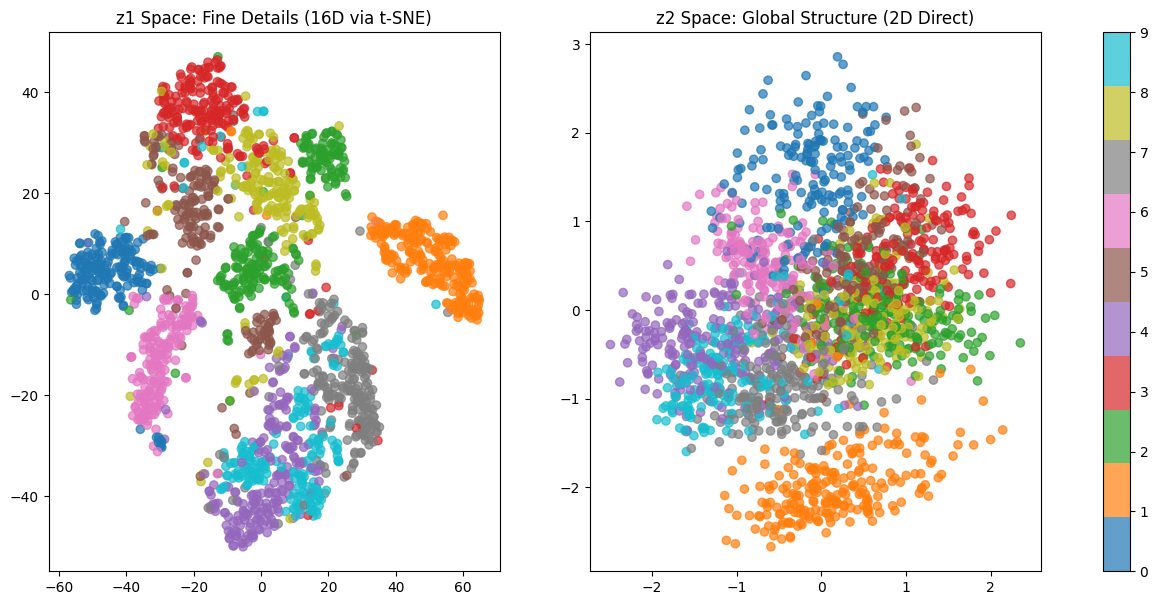

In [ ]:
def plot_both_latent_spaces(model, dataloader, config, num_samples=2000):
    model.eval()
    z1_points, z2_points, labels = [], [], []

    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(config.device)
            # Run inference
            _, q_mu1, _, q_mu2, _, _, _, _, _ = model(data)

            z1_points.append(q_mu1.cpu().numpy())
            z2_points.append(q_mu2.cpu().numpy())
            labels.append(label.numpy())

            if len(np.concatenate(z1_points)) >= num_samples:
                break

    z1_points = np.concatenate(z1_points, axis=0)[:num_samples]
    z2_points = np.concatenate(z2_points, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]

    print("Running t-SNE on z1...")
    z1_2d = TSNE(n_components=2, random_state=42).fit_transform(z1_points)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Plot z1 (t-SNE)
    scatter1 = ax1.scatter(z1_2d[:, 0], z1_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    ax1.set_title(f"z1 Space: Fine Details (16D via t-SNE)")

    # Plot z2 (Direct)
    scatter2 = ax2.scatter(z2_points[:, 0], z2_points[:, 1], c=labels, cmap='tab10', alpha=0.7)
    ax2.set_title(f"z2 Space: Global Structure (2D Direct)")

    fig.colorbar(scatter2, ax=[ax1, ax2], ticks=range(10))
    plt.show()

plot_both_latent_spaces(model, test_loader, config)

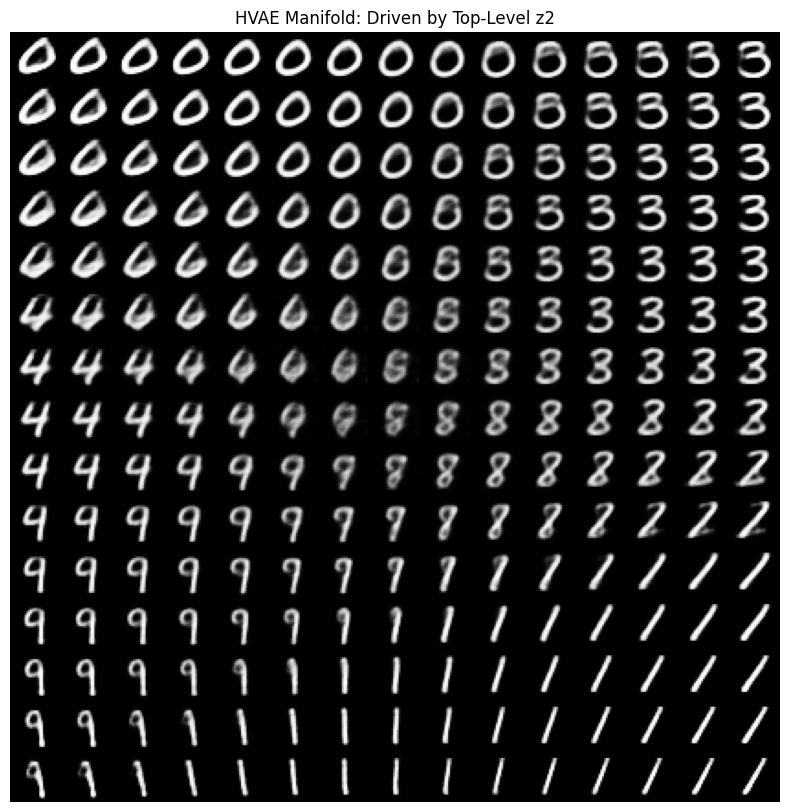

In [ ]:
def plot_hvae_manifold(model, config, grid_size=15, bound=2.5):
    model.eval()
    x_coords = np.linspace(-bound, bound, grid_size)
    y_coords = np.linspace(bound, -bound, grid_size)

    figure = np.zeros((28 * grid_size, 28 * grid_size))

    with torch.no_grad():
        for i, yi in enumerate(y_coords):
            for j, xi in enumerate(x_coords):
                # 1. Create the 2D z2 vector
                z2 = torch.tensor([[xi, yi]], dtype=torch.float32).to(config.device)

                # 2. Pass top-down: get the expected z1 from z2
                h_p2 = F.relu(model.dec2(z2))
                expected_z1 = model.dec2_mu(h_p2) # We use the mean of the prior

                # 3. Decode z1 into the image
                h_out = F.relu(model.dec1(expected_z1))
                generated_image = torch.sigmoid(model.dec1_out(h_out))

                generated_image = generated_image.cpu().view(28, 28).numpy()
                figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = generated_image

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.axis('off')
    plt.title("HVAE Manifold: Driven by Top-Level z2")
    plt.show()

plot_hvae_manifold(model, config)